## Descripción del proyecto

Interconnect operador de telecomunicaciones busca poder pronosticar su tasa de cancelación, para ofrecer códigos promocionales y opciones de planes especiales a los clientes que planean irse.

El equipo de marketing de Interconnect se encargó de recopilar algunos de los datos personales de sus clientes, información sobre sus planes y contratos.
 

#### Servicios de Interconnect 

Interconnect ofrece dos tipos de servicios principalmente:

 
1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.

2. Internet. La red se puede configurar a través de una línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.

Otros servicios que ofrece la empresa:
* Seguridad en Internet: software antivirus (ProtecciónDeDispositivo) y un bloqueador de sitios web maliciosos (SeguridadEnLínea).
* Una línea de soporte técnico (SoporteTécnico).
* Almacenamiento de archivos en la nube y backup de datos (BackupOnline).
* Streaming de TV (StreamingTV) y directorio de películas (StreamingPelículas)

Los clientes pueden elegir entre un pago mensual o un contrato de 1 o 2 años, con varios métodos de pago. La información del contrato es válida a partir del 1 de febrero de 2020. 

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

`df_contract`

* begin_date: Fecha de inicio del contrato del cliente con la empresa.
* end_date: Fecha de finalización del contrato (si aplica); si está en NaN, el cliente sigue activo.
* type: Tipo de contrato (mensual, anual, o por dos años).
* monthly_charges: Monto que el cliente paga mensualmente por el servicio. 
* total_charges: Total acumulado que el cliente ha pagado desde el inicio del contrato.
* paperless_billing: Indica si el cliente optó por facturación electrónica (sí/no).
* payment_method:  Método de pago usado por el cliente (tarjeta de crédito, débito automático, transferencia bancaria, entre otras)



`df_personal` 

* gender: Género del cliente (Femenino/Masculino).
* senior_citizen:  Indica si el cliente es una persona mayor.
* partner: Indica si el cliente tiene pareja.
* dependents: Indica si el cliente tiene personas a su cargo, como hijos u otros dependientes.

`df_internet` 

* internet_service: Tipo de conexión a internet que tiene el cliente (por ejemplo: DSL, fibra óptica, sin servicio).
* online_security: Indica si el cliente tiene contratado un servicio de seguridad en línea (antivirus/firewall).
* online_backup: Indica si el cliente tiene contratado un servicio de respaldo en la nube.
* device_protection: Indica si el cliente tiene protección para sus dispositivos.
* tech_support: Indica si el cliente tiene soporte técnico adicional contratado.
* streaming_tv: Indica si el cliente tiene acceso a un servicio de TV por streaming.
* streaming_movies: Indica si el cliente tiene acceso a un servicio de películas por streaming.

`df_phone` 

* multiple_lines: Indica si el cliente tiene múltiples líneas telefónicas (sí/no).

### Objetivo | Métricas 

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: Exactitud (Accuracy)


## 01 Preparación de datos

Importación de librerías 

In [1]:
import numpy as np  
import pandas as pd   

import math
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve

Leer archivos

In [2]:
# Leer los datos proporcionado por el cliente 

df_contract = pd.read_csv('data_raw/contract.csv')
df_personal = pd.read_csv('data_raw/personal.csv')
df_internet = pd.read_csv('data_raw/internet.csv')
df_phone = pd.read_csv('data_raw/phone.csv')

Vista general de archivos 

In [ ]:
# Verificar la carga de los datos y su estructura

df_contract.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
df_contract.duplicated().sum()


0

In [ ]:
# Verificar la carga de los datos y su estructura
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
df_personal.duplicated().sum()


0

In [8]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
# Verificar la carga de los datos y su estructura

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
df_internet.duplicated().sum()

0

In [11]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
# Verificar la carga de los datos y su estructura

df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
df_phone.duplicated().sum()

0

In [14]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Observaciones:

* El formato de los dataframe es del tipo CamelCase, se convertirá a tipo snake_case para facilitar el manejo de los datos.
* Los data frames no contienen el mismo número de filas.
* Contract:
    - La columna 'TotalCharges' se debe convertir al tipo float
    - BeginDate y EndDate deben convertirse al tipo DateTime
    - Se puede tomar como base EndDate para crear una variable 'churned' que almacene datos 0 y 1 en caso de cancelación.
    - Las variables 'type', 'PaperlessBilling' y 'PaymentMethod' se pueden codificar.
* Personal e Internet:
    - Todas sus columnas contienen datos categóricos, que se pueden codificar, a 0 y 1,  excepto costumerID
* Phone:
    - Solo contiene una columna que solo contiene valores yes/no y puede codificarse.




### Preprocesamiento

Formato snake_case

In [15]:
# Cambiar formato de dataframes de CamelCase a snake_case

def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Aplicar a cada DataFrame por separado
df_contract.columns = [to_snake_case(col) for col in df_contract.columns]
df_personal.columns = [to_snake_case(col) for col in df_personal.columns]
df_internet.columns = [to_snake_case(col) for col in df_internet.columns]
df_phone.columns = [to_snake_case(col) for col in df_phone.columns]

Unir data frames

In [16]:
# Unir todos los DataFrames usando 'customerID' como clave

df_conjunto = df_contract.merge(df_personal, on='customer_id', how='left') \
                       .merge(df_internet, on='customer_id', how='left') \
                       .merge(df_phone, on='customer_id', how='left')

In [17]:
df_conjunto.shape
df_conjunto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Columna Target 

In [18]:
# Crear columna churned para indicar si el cliente ha cancelado el contrato
df_conjunto['churned'] = df_conjunto['end_date'].apply(lambda x: 0 if x == 'No' else 1)



Cambiar tipo de datos 

In [19]:
# Reemplazar 'No' con NaT y convertir a datetime
df_conjunto['end_date'] = df_conjunto['end_date'].replace('No', pd.NaT)
df_conjunto['end_date'] = pd.to_datetime(df_conjunto['end_date'])


In [20]:
# Convertir las columnas de fecha a tipo datetime
df_conjunto['begin_date'] = pd.to_datetime(df_conjunto['begin_date'], format='%Y-%m-%d')

In [21]:
# Convertir columna monthly_charges a float 
df_conjunto['monthly_charges'] = df_conjunto['monthly_charges'].astype(float)

In [22]:
# Cambiar el tipo de dato de la columna total_charges a float
df_conjunto['total_charges'] = pd.to_numeric(df_conjunto['total_charges'], errors='coerce')


Celdas sin información (NaN)

In [23]:
# Revisar si hay valores nulos en el DataFrame combinado
df_conjunto.isnull().sum()



customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
churned                 0
dtype: int64

In [24]:

# Filtrar filas donde total_charges tiene valores faltantes (NaN)
missing_total_charges = df_conjunto[df_conjunto['total_charges'].isna()]


In [25]:
print(f"Número de filas con total_charges faltantes: {missing_total_charges.shape[0]}")
print(f"Proporción: {missing_total_charges.shape[0] / df_conjunto.shape[0]:.2%}")

Número de filas con total_charges faltantes: 11
Proporción: 0.16%


In [26]:
# Eliminar las filas con valores faltantes en total_charges 
df_conjunto = df_conjunto.dropna(subset=['total_charges'])

In [27]:
# Eliminar filas con valores faltantes en internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
df_conjunto = df_conjunto.dropna(subset=['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'])

In [28]:
# Eliminar filas con valores faltantes multiple_lines
df_conjunto = df_conjunto.dropna(subset=['multiple_lines'])

In [29]:
# Confirmar que no hay valores nulos en el DataFrame combinado

df_conjunto.isna().sum()

customer_id             0
begin_date              0
end_date             3246
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
churned                 0
dtype: int64

Duplicados

In [30]:
# Revisar si hay duplicados en el DataFrame por la columna customer_id
df_conjunto.duplicated(subset=['customer_id']).sum()

0

In [31]:
# Confirmar que no hay valores repetidos en el DataFrame por la columna customer_id
df_conjunto['customer_id'].nunique()

4832

Creación de variables para modelo

In [32]:
# Definir la fecha de corte para el análisis
cutoff_date = pd.to_datetime('2020-02-01')

In [33]:
# Crear la columna 'contract_duration' en días

df_conjunto['contract_duration'] = (
    df_conjunto['end_date'].fillna(cutoff_date) - df_conjunto['begin_date']
).dt.days

In [34]:
# Crear variables mes y año en que se inicio el contrato

df_conjunto['begin_month'] = df_conjunto['begin_date'].dt.month
df_conjunto['begin_year'] = df_conjunto['begin_date'].dt.year

In [35]:
df_conjunto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 1 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        4832 non-null   object        
 1   begin_date         4832 non-null   datetime64[ns]
 2   end_date           1586 non-null   datetime64[ns]
 3   type               4832 non-null   object        
 4   paperless_billing  4832 non-null   object        
 5   payment_method     4832 non-null   object        
 6   monthly_charges    4832 non-null   float64       
 7   total_charges      4832 non-null   float64       
 8   gender             4832 non-null   object        
 9   senior_citizen     4832 non-null   int64         
 10  partner            4832 non-null   object        
 11  dependents         4832 non-null   object        
 12  internet_service   4832 non-null   object        
 13  online_security    4832 non-null   object        
 14  online_backup

In [36]:
# Hacer una copia del Data frame antes de binarizar y hacer one hot encoding
df_raw= df_conjunto.copy()

Binarizar columnas  yes / no 

In [37]:
def binarizar_columnas(df, columnas):
    """
    Convierte valores 'yes' en 1 y el resto en 0 para las columnas indicadas.
    Devuelve una copia del DataFrame con las columnas modificadas.
    """
    df = df.copy()
    for col in columnas:
        df[col] = df[col].astype(str).str.strip().str.lower()
        df[col] = (df[col] == 'yes').astype(int)
    return df

In [38]:
columnas_binarias = ['partner', 'dependents', 'online_security', 'online_backup',
                     'device_protection', 'tech_support', 'streaming_tv',
                     'streaming_movies', 'multiple_lines', 'paperless_billing']


In [39]:
# Binarización
df_conjunto = binarizar_columnas(df_raw, columnas_binarias)

Codificación OHE

In [40]:
def aplicar_ohe(df, columnas):
    df = df.copy()
    df_ohe = pd.get_dummies(df[columnas], drop_first=True).astype(int)
    df = df.join(df_ohe).drop(columnas, axis=1)
    return df

In [41]:
columnas_ohe = ['type', 'payment_method', 'internet_service', 'gender']

In [42]:
# One-hot encoding
df_conjunto = aplicar_ohe(df_conjunto, columnas_ohe)

In [43]:
df_conjunto

,customer_id,begin_date,end_date,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,...,contract_duration,begin_month,begin_year,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,gender_Male
1,5575-GNVDE,2017-04-01,NaT,0,56.95,1889.50,0,0,0,1,...,1036,4,2017,1,0,0,0,1,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,1,53.85,108.15,0,0,0,1,...,61,10,2019,0,0,0,0,1,0,1
4,9237-HQITU,2019-09-01,2019-11-01,1,70.70,151.65,0,0,0,0,...,61,9,2019,0,0,0,1,0,1,0
5,9305-CDSKC,2019-03-01,2019-11-01,1,99.65,820.50,0,0,0,0,...,245,3,2019,0,0,0,1,0,1,0
6,1452-KIOVK,2018-04-01,NaT,1,89.10,1949.40,0,0,1,0,...,671,4,2018,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,8456-QDAVC,2018-07-01,NaT,1,78.70,1495.10,0,0,0,0,...,580,7,2018,0,0,0,0,0,1,1
7038,6840-RESVB,2018-02-01,NaT,1,84.80,1990.50,0,1,1,1,...,730,2,2018,1,0,0,0,1,0,1
7039,2234-XADUH,2014-02-01,NaT,1,103.20,7362.90,0,1,1,0,...,2191,2,2014,1,0,1,0,0,1,0
7041,8361-LTMKD,2019-07-01,2019-11-01,1,74.40,306.60,1,1,0,0,...,123,7,2019,0,0,0,0,1,1,1


Observaciones:

- Los datos del df_internet, no contiene todos los registros de clientes iguales a los del df_contract. Se eliminaron las filas que no tienen información que coincida con los otros dataframes.
- Se eliminaron registros que tenían valores ausentes en 'total_charges', representaban menos de 1% del conjunto.
- Los tipos de dato 'object' se cambiaron al tipo 'int' para su manipulación
- Se codificaron las variables que contenían más de dos tipos de categorías.


## 02 Análisis Exploratorio de Datos (EDA)

#### Distribución de variables 


In [ ]:
# Paleta de colores del proyecto 

custom_palette = ['#0D2CD9', '#04B2D9', '#94F207']

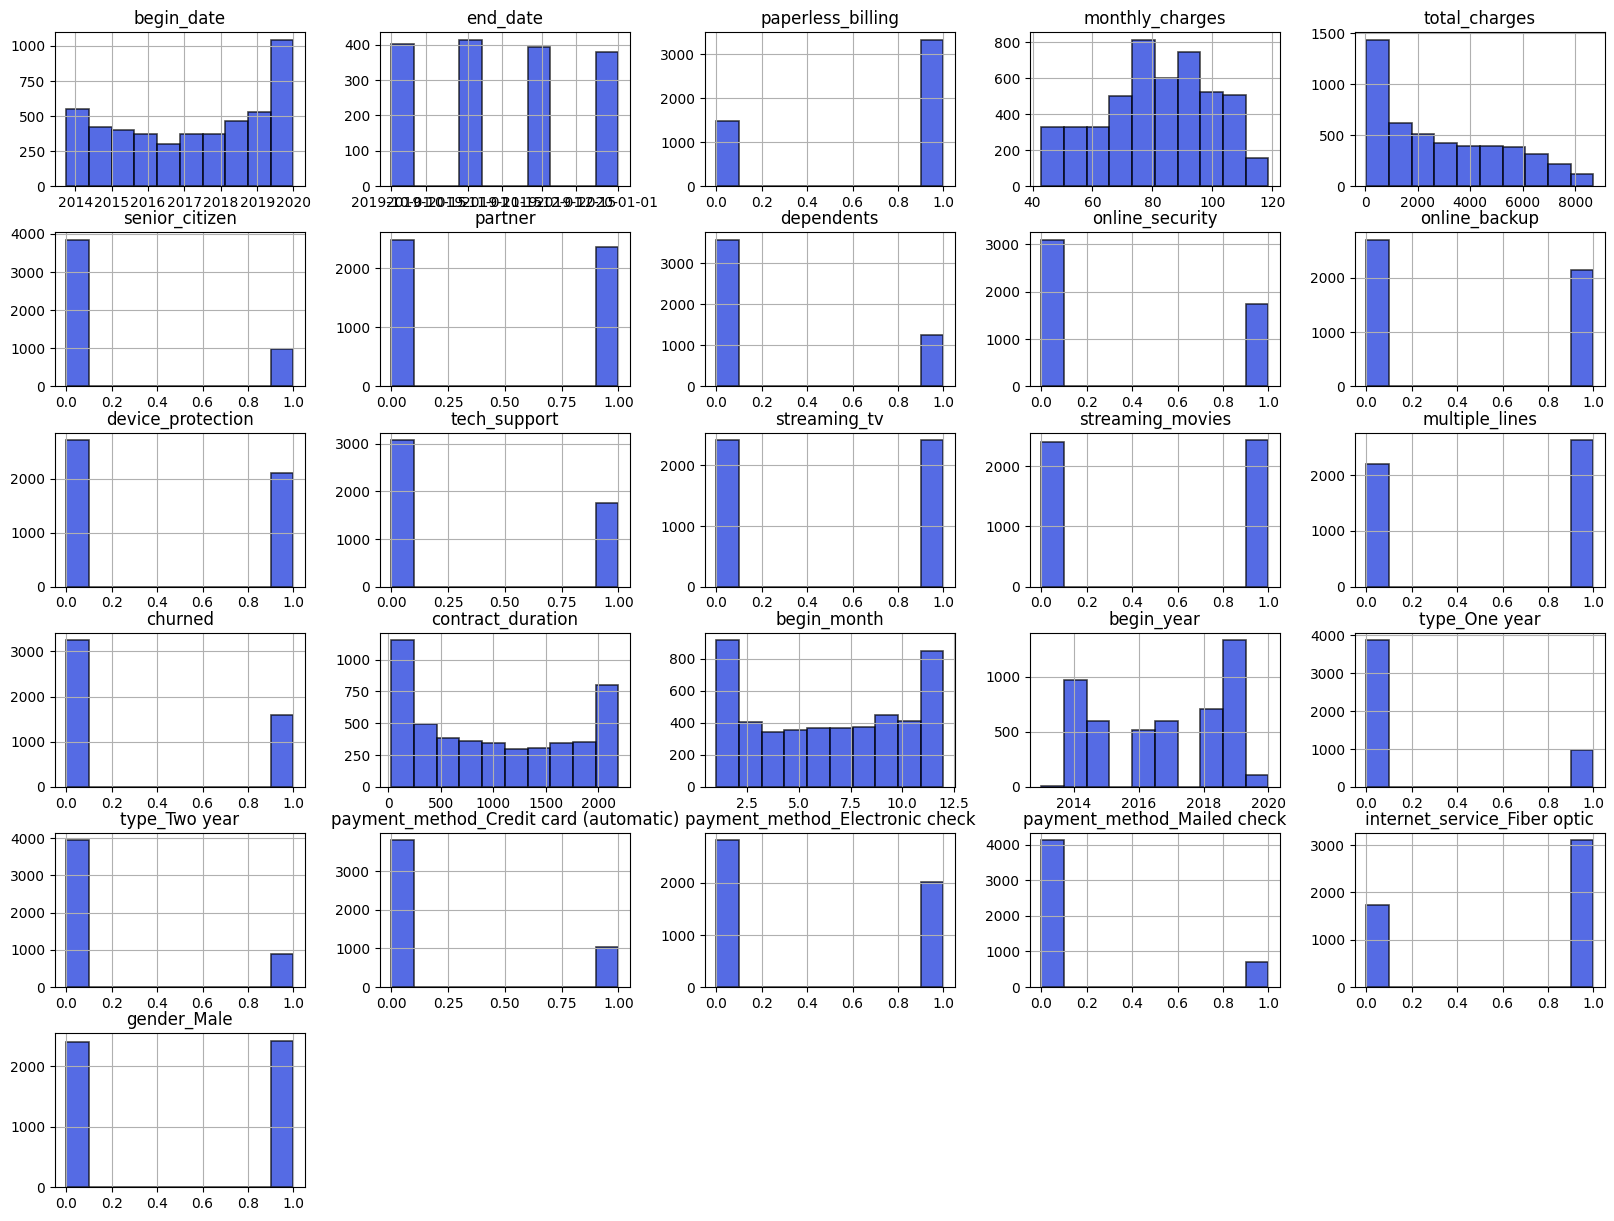

In [ ]:
# Histograma de las variables numéricas

df_conjunto.hist(edgecolor='black', linewidth=1.2, figsize=(20,15),color='#0D2CD9', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.3)


In [ ]:
# Descripción de metricas de la variable contract_duration

df_conjunto['contract_duration'].describe()


count    4832.000000
mean     1006.814363
std       749.932028
min        30.000000
25%       276.000000
50%       914.000000
75%      1706.000000
max      2191.000000
Name: contract_duration, dtype: float64

Observaciones:

* La distribución de los cargos totales está sesgada hacia la izquierda (positivamente), hay una alta concentración de valores bajos y hay pocos valores muy altos. Con esto podríamos intuir que hay un gran número de clientes con poca antigüedad o de bajo consumo.
* Tenemos los dos extremos: Alto número de clientes con hasta 6 años de antigüedad y varios clientes con contratos de un mes. El promedio de duración de contrato de los datos proporcionados es de 2 años y medio aprox.  
* Los meses en que más contratos se iniciaron en febrero, seguido por octubre que podría indicarnos algún tipo de patrón por estacionalidad.
* Podemos observar que la proporción entre no cancelado y cancelado, es 2:1, que indica un desbalance moderado. Tomaremos en cuenta este desbalance al entrenar el modelo.


#### Correlación entre características y objetivo

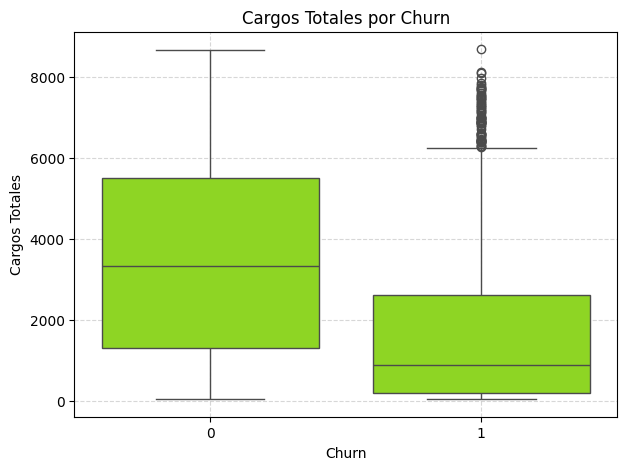

In [47]:
# Distribución de los cargos totales y las cancelaciones

plt.figure(figsize=(7, 5))
sns.boxplot(x='churned', y='total_charges', data=df_conjunto, color='#94F207')
plt.title('Cargos Totales por Churn')   
plt.xlabel('Churn')
plt.ylabel('Cargos Totales')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


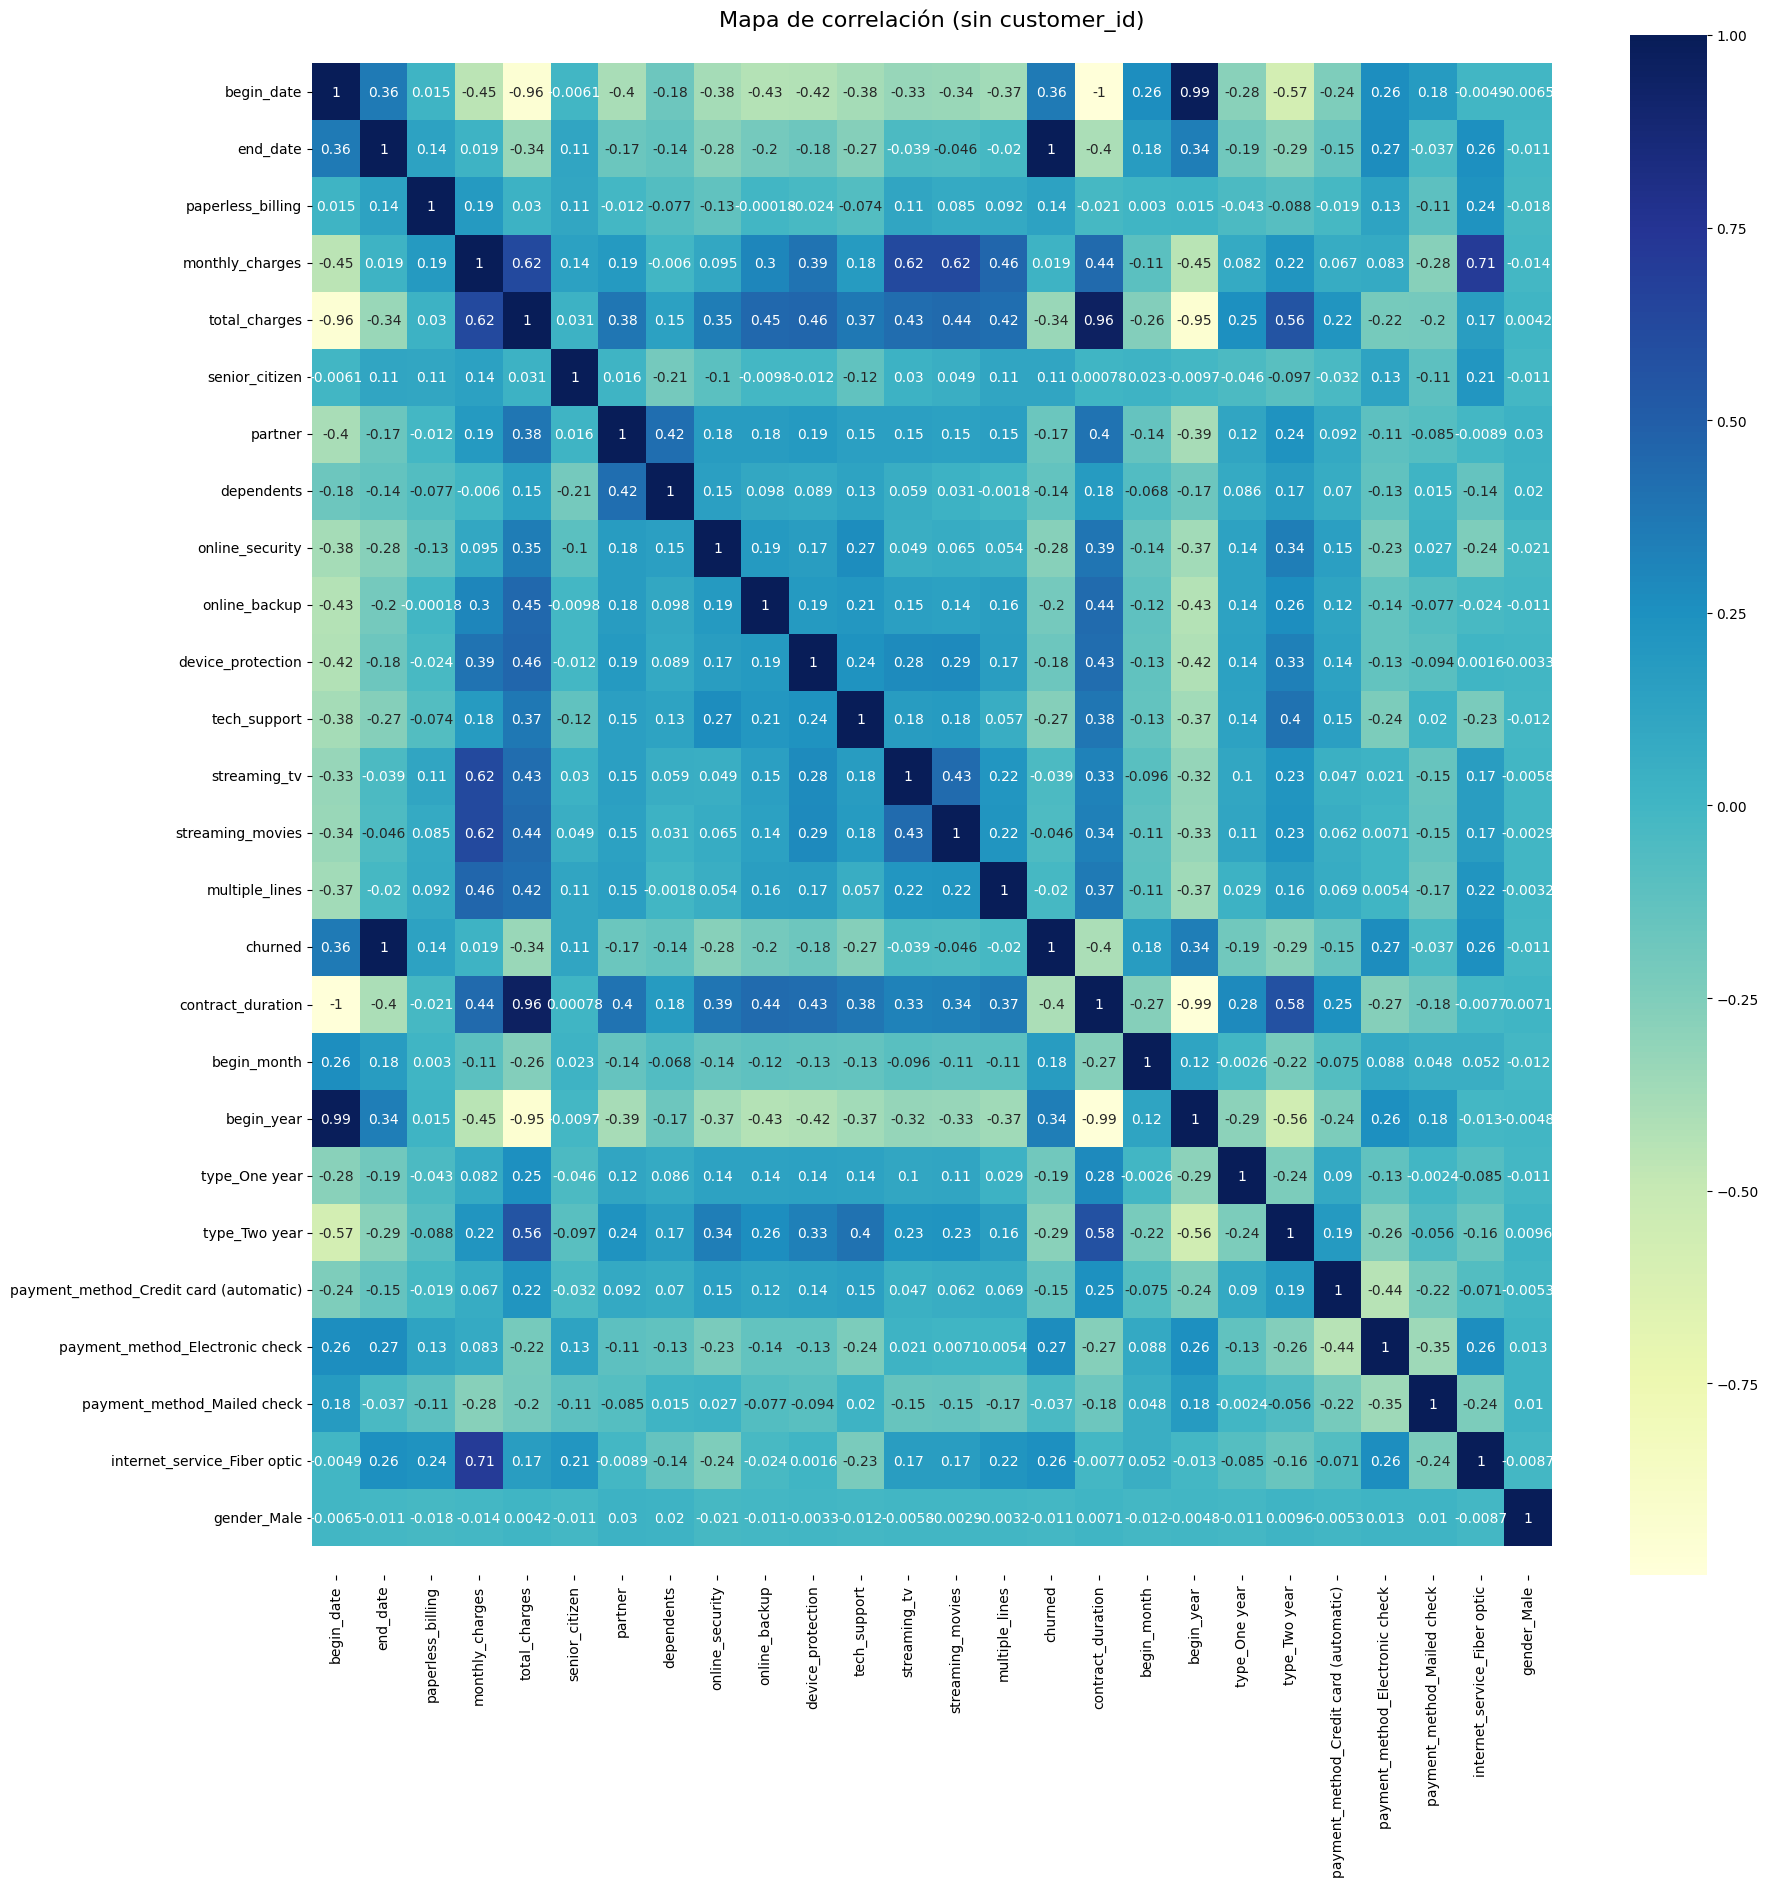

In [ ]:
# Grafico de correlación entre variables

plt.figure(figsize=(20, 20))

# Excluye 'customer_id' del análisis
df_corr = df_conjunto.drop('customer_id', axis=1)

# Calcula la correlación y genera el heatmap
ax = sns.heatmap(df_corr.corr(), annot=True, cmap='YlGnBu')

# Caracteristicas de la visualización
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.title('Mapa de correlación (sin customer_id)', fontsize=16)
plt.show()

Observaciones: 

* De las variables categóricas, algunas presentan desbalance notorios entre ellas. En el heatmap notamos que los contratos del tipo mes a mes tienen una alta relación con la cancelación de contratos, seguidos por aquellos que realizan el pago electrónico, que tienen un servicio de fibra óptica y son personas mayores a 60 años. 
* Gran parte de los casos que han cancelado, son aquellos con cargos totales menores a 3000, posibles casos con poca satisfacción de servicio, problemas con el mismo o alguna variante externa o relacionado al tipo de plan que tengan contratado. 



## 03 Modelos

Se utilizó un modelo de clasificación,el objetivo es predecir una variable categórica: el cliente cancela o no cancela. 

In [50]:

# Data frame que contenga solo las variables que se van a usar para el modelo

columnas_a_excluir = ['begin_date', 'end_date', 'multiple_lines', 'customer_id']
df_modelo = df_conjunto.drop(columns=columnas_a_excluir, errors='ignore')

In [51]:
df_modelo.head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,contract_duration,begin_month,begin_year,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,gender_Male
1,0,56.95,1889.50,0,0,0,1,0,1,0,...,1036,4,2017,1,0,0,0,1,0,1
2,1,53.85,108.15,0,0,0,1,1,0,0,...,61,10,2019,0,0,0,0,1,0,1
4,1,70.70,151.65,0,0,0,0,0,0,0,...,61,9,2019,0,0,0,1,0,1,0
5,1,99.65,820.50,0,0,0,0,0,1,0,...,245,3,2019,0,0,0,1,0,1,0
6,1,89.10,1949.40,0,0,1,0,1,0,0,...,671,4,2018,0,0,1,0,0,1,1


In [ ]:
# Variable para las columnas categóricas 

numeric_cols = ['contract_duration', 'monthly_charges', 'total_charges','begin_month', 'begin_year']

In [53]:
# Crear el escalador
scaler = StandardScaler()

# Aplicar el escalado solo a las columnas numéricas

df_modelo[numeric_cols] = scaler.fit_transform(df_modelo[numeric_cols]) # AQUI ME QUEDE

In [54]:
# Defnir variables predictoras y variable objetivo
X = df_modelo.drop(columns=['churned'])
y = df_modelo['churned']

In [55]:
# Separar los datos en conjunto de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [56]:
# Aplicar SMOTE solo en entrenamiento
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [57]:
print("Antes del SMOTE:", y_train.value_counts())
print("Después del SMOTE:", y_train_res.value_counts())

Antes del SMOTE: churned
0    2596
1    1269
Name: count, dtype: int64
Después del SMOTE: churned
0    2596
1    2076
Name: count, dtype: int64


### 00. Modelo Dummy 

In [58]:
# Entrenar modelo Dummy Classifier, que sirve como baseline

dummy = DummyClassifier(strategy='most_frequent')  
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Dummy Model Report:\n")
print(classification_report(y_test, y_pred_dummy))

Dummy Model Report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       650
           1       0.00      0.00      0.00       317

    accuracy                           0.67       967
   macro avg       0.34      0.50      0.40       967
weighted avg       0.45      0.67      0.54       967



c:\Users\Fernanda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fernanda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fernanda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### 01. LightGBM 

In [81]:
# Entrenar el modelo LightGBM con class_weight balanced
# Comprobar que  la variable objetivo sea binaria

y_train = y_train.astype('int')

lgb_model = lgb.LGBMClassifier(
    max_depth=3,               
    num_leaves=6,             
    min_child_samples=100,     
    subsample=0.6,             
    colsample_bytree=0.6,      
    learning_rate=0.05,        
    n_estimators=600,         
)

# Entrenar el modelo

lgb_model.fit( X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
 )



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2076, number of negative: 2596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 4672, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444349 -> initscore=-0.223529
[LightGBM] [Info] Start training from score -0.223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.05, max_depth=3,
               min_child_samples=100, n_estimators=600, num_leaves=6,
               subsample=0.6)

In [82]:
# Predicciones con el modelo LightGBM, conjunto de entrenamiento

y_pred_train = lgb_model.predict(X_train_res)
y_proba_train = lgb_model.predict_proba(X_train_res)[:, 1]

# Reporte Entrenamiento 
print("Conjunto de Entrenamiento Modelo LightGBM:")
print()
print("Accuracy:", accuracy_score(y_train_res, y_pred_train))
print("AUC-ROC:", roc_auc_score(y_train_res, y_proba_train))
print()
print(classification_report(y_train_res, y_pred_train))



Conjunto de Entrenamiento Modelo LightGBM:

Accuracy: 0.953125
AUC-ROC: 0.985729304903646

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2596
           1       0.99      0.91      0.94      2076

    accuracy                           0.95      4672
   macro avg       0.96      0.95      0.95      4672
weighted avg       0.96      0.95      0.95      4672



In [83]:
# Predicciones con el modelo LightGBM, conjunto de prueba

y_pred_test = lgb_model.predict(X_test)
y_proba_test = lgb_model.predict_proba(X_test)[:, 1]

print("Conjunto de Prueba Modelo LightGBM:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_test))
print()
print(classification_report(y_test, y_pred_test))


Conjunto de Prueba Modelo LightGBM:

Accuracy: 0.9451913133402275
AUC-ROC: 0.9749769473428779

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       650
           1       0.98      0.85      0.91       317

    accuracy                           0.95       967
   macro avg       0.96      0.92      0.94       967
weighted avg       0.95      0.95      0.94       967



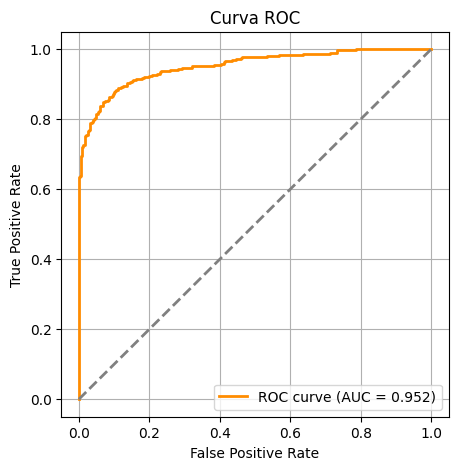

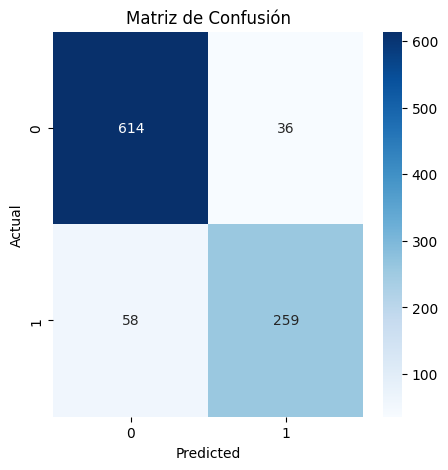

C:\Users\Fernanda\AppData\Local\Temp\ipykernel_16108\3465940809.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='cividis')


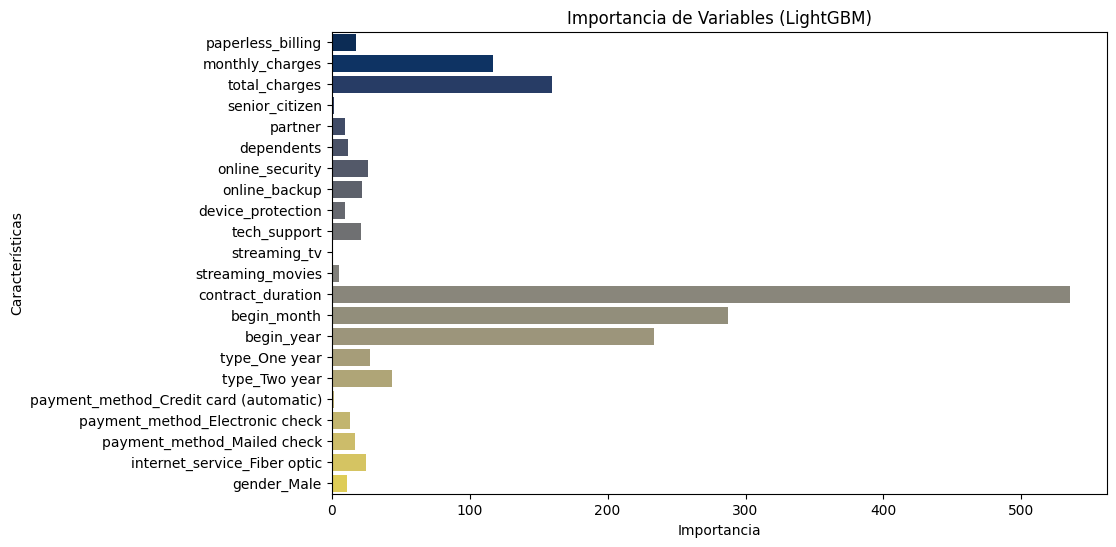

In [62]:
# Graficar curva ROC y matriz de confusión

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# --- Importancia de variables ---
importances = lgb_model.feature_importances_
features = X_test.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette='cividis')
plt.title('Importancia de Variables (LightGBM)')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

Observaciones:

- En el conjunto de prueba, al tener los datos balanceados por SMOTE, obtuvimos métricas igual a 1, que puede indicar sobreajuste. El modelo está memorizando perfectamente los datos
- Para el conjunto de prueba, donde no se realizó un balanceo con SMOTE y se tomaron los datos reales, obtuvimos Accuracy: 0.99 y AUC-ROC: 0.9975 que indica que el modelo esta funcionando muy bien, no se sobreajusto y tiene una gran capacidad de discriminación.  
 

### 02. Logistic Regression

In [63]:
# Entrenamiento con los datos balanceados 

logreg_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

logreg_model.fit( X_train_res, y_train_res) 

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [64]:
# Predicciones en entrenamiento 
y_pred_train_logr = logreg_model.predict(X_train_res)
y_proba_train_logr = logreg_model.predict_proba(X_train_res)[:, 1]

# Evaluación entrenamiento
print("Conjunto de Entrenamiento Modelo Logistic Regression:")
print()
print("Accuracy:", accuracy_score(y_train_res, y_pred_train_logr))
print("AUC-ROC:", roc_auc_score(y_train_res, y_proba_train_logr))
print()
print(classification_report(y_train_res, y_pred_train_logr))

Conjunto de Entrenamiento Modelo Logistic Regression:

Accuracy: 0.9351455479452054
AUC-ROC: 0.9831491905436257

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2596
           1       0.92      0.93      0.93      2076

    accuracy                           0.94      4672
   macro avg       0.93      0.93      0.93      4672
weighted avg       0.94      0.94      0.94      4672



In [65]:
# Predicones en prueba
y_pred_test_logr = logreg_model.predict(X_test)
y_proba_test_logr = logreg_model.predict_proba(X_test)[:, 1]

# Evaluación prueba
print("Conjunto de Prueba Modelo Logistic Regression:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_test_logr))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_test_logr))
print()
print(classification_report(y_test, y_pred_test_logr))

Conjunto de Prueba Modelo Logistic Regression:

Accuracy: 0.9255429162357808
AUC-ROC: 0.9801989808298956

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       650
           1       0.87      0.91      0.89       317

    accuracy                           0.93       967
   macro avg       0.91      0.92      0.92       967
weighted avg       0.93      0.93      0.93       967



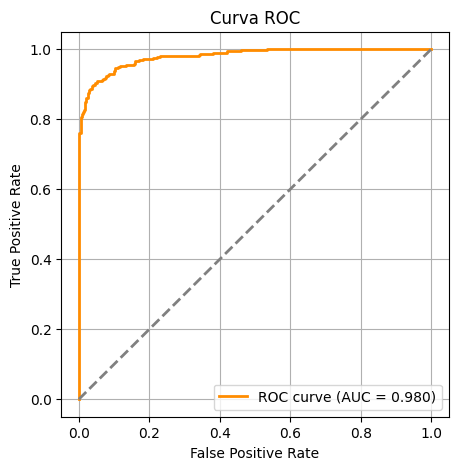

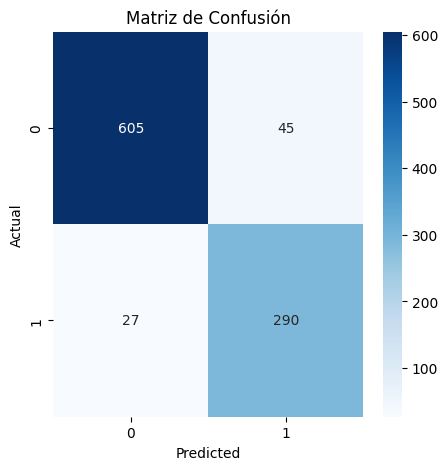

In [66]:
# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba_test_logr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred_test_logr)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


Observaciones: 

- El modelo para el conjunto de entrenamiento, con los datos balanceados y el conjunto de prueba no presentan gran diferencia entre los resultados. Esto nos indica que el modelo de Regresión Logística también está detectando de manera muy precisa los casos de posible cancelación.


### 03. CatBoost Classifier

In [67]:
# Crear y entrenar el modelo CatBoost

catboost_model = CatBoostClassifier(
    iterations=180,
    learning_rate=0.05,
    depth=4,
    class_weights=[1, 1.3],
    random_seed=42,
    verbose=False
)

catboost_model.fit(X_train_res, y_train_res,eval_set=(X_test, y_test),
    early_stopping_rounds=30,
    verbose=False)


In [68]:
# Predicciones
y_train_pred_catb = catboost_model.predict(X_train_res)
y_train_proba_catb = catboost_model.predict_proba(X_train_res)[:, 1]

# Evaluación
print("Conjunto de Entrenamiento Modelo CatBoost:")
print()
print("Accuracy:", accuracy_score(y_train_res, y_train_pred_catb))
print("AUC-ROC:", roc_auc_score(y_train_res, y_train_proba_catb))
print()
print(classification_report(y_train_res, y_train_pred_catb))

Conjunto de Entrenamiento Modelo CatBoost:

Accuracy: 0.9034674657534246
AUC-ROC: 0.9679993453690426

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2596
           1       0.89      0.89      0.89      2076

    accuracy                           0.90      4672
   macro avg       0.90      0.90      0.90      4672
weighted avg       0.90      0.90      0.90      4672



In [69]:
y_test_pred_catb = catboost_model.predict(X_test)
y_test_proba_catb = catboost_model.predict_proba(X_test)[:, 1]


print("Conjunto de Prueba Modelo CatBoost:")
print()
print("Accuracy:", accuracy_score(y_test, y_test_pred_catb))
print("AUC-ROC:", roc_auc_score(y_test, y_test_proba_catb))
print()
print(classification_report(y_test, y_test_pred_catb))

Conjunto de Prueba Modelo CatBoost:

Accuracy: 0.8841778697001034
AUC-ROC: 0.9501286095607862

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       650
           1       0.82      0.84      0.83       317

    accuracy                           0.88       967
   macro avg       0.87      0.87      0.87       967
weighted avg       0.89      0.88      0.88       967



Observaciones:

- El modelo se entrena de manera efectiva por el grupo de datos balanceados que se le ha dado. Esto le permite tener altos valores en las métricas requeridas en el conjunto de prueba, con un AUC-ROC: 0.9514 y Accuracy: 0.88


In [85]:
# Tabla de resultados
 
resultados = pd.DataFrame({
    'Modelo': ['Dummy', 'LightGBM', 'Logistic Regression', 'CatBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_test),
        accuracy_score(y_test, y_pred_test_logr),
        accuracy_score(y_test, y_test_pred_catb)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_dummy),
        roc_auc_score(y_test, y_proba_test),
        roc_auc_score(y_test, y_proba_test_logr),
        roc_auc_score(y_test, y_test_proba_catb)
    ]
})

In [86]:
# Ordenar resultados por AUC-ROC
resultados = resultados.sort_values(by='AUC-ROC', ascending=False).reset_index(drop=True)
print(resultados)


                Modelo  Accuracy   AUC-ROC
0  Logistic Regression  0.925543  0.980199
1             LightGBM  0.945191  0.974977
2             CatBoost  0.884178  0.950129
3                Dummy  0.672182  0.500000


## 04 Conclusiones 




El objetivo del proyecto fue desarrollar un modelo de clasificación capaz de predecir con alta precisión si un cliente abandonará el servicio de Interconnect, facilitando así la implementación de estrategias de retención personalizadas. Para considerar el modelo como válido, se estableció un umbral mínimo de AUC-ROC ≥ 0.75, además de evaluar otras métricas de rendimiento como accuracy y F1-score.

Durante el proceso de análisis exploratorio, se identificaron y corrigieron valores ausentes y tipos de datos inconsistentes. Asimismo, se generaron nuevas variables útiles a partir de las existentes. La mayoría de las columnas eran categóricas, por lo que se codificaron adecuadamente para su uso en modelos de Machine Learning.

Dado el fuerte desbalance en la variable objetivo, se aplicó la técnica SMOTE únicamente al conjunto de entrenamiento, permitiendo mejorar la capacidad del modelo para aprender patrones sin afectar la evaluación sobre datos no vistos.

Al comparar distintos modelos, LightGBM demostró ser el más efectivo, con un AUC-ROC de 0.975 y una accuracy del 94.5%, superando ampliamente al baseline representado por el modelo Dummy (AUC-ROC de 0.50). Aunque el modelo de Regresión Logística también presentó buenos resultados, LightGBM ofreció un mejor equilibrio entre sensibilidad y precisión.

En consecuencia, LightGBM se considera el modelo más adecuado para ser implementado, ya que cumple con los requisitos establecidos y ofrece una herramienta confiable para anticipar la pérdida de clientes y tomar acciones proactivas para su retención.

